# **Assignment Week 3 - Time Series Forecasting**

This assignment explores time series analysis and forecasting techniques using a selected dataset. 
The goal is to analyze trends, model patterns, and predict future values.

🔹 Key Tasks Covered:

Data Import & Preprocessing – Loading time series data from .csv or .xlsx files using pandas.
Time Series Visualization – Plotting the data to identify trends and seasonality.
Model Selection & Forecasting – Implementing statistical models for time series prediction.

📂 Tools & Libraries Used:
✔ pandas – Data handling and manipulation
✔ matplotlib – Data visualization
✔ statsmodels / scikit-learn – Time series modeling

**Import the Libraries**

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

**Load the Dataset**

If your dataset is a .csv file, use the pandas function *read_csv*, if it's a .xlsx file, use *read_excel*

In [229]:
# Load data
# Load dataset
data = pd.read_csv('Monthly_Google_Search_Iceland_Reykjavik.csv', parse_dates=['Month'], index_col='Month')
data.columns = ['Reykjavik_Search']  # Rename column for clarity
data

,Reykjavik_Search
Month,
2004-01-01,8
2004-02-01,7
2004-03-01,8
2004-04-01,7
2004-05-01,10
...,...
2024-07-01,57
2024-08-01,64
2024-09-01,52


**Plot the time series**

Do not split the dataset yet, just plot the time series

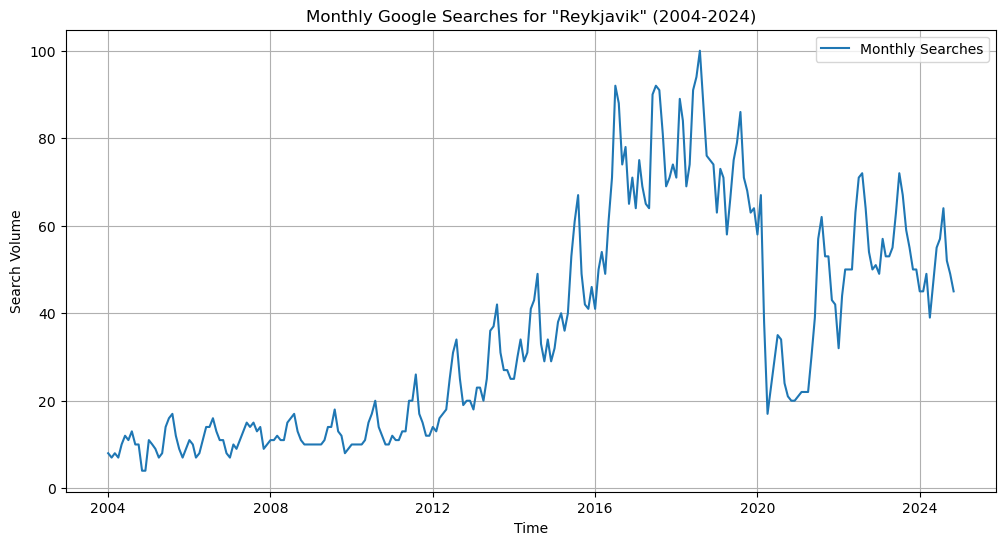

In [230]:
# Plot


# Plot the entire time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Reykjavik_Search'], label='Monthly Searches')
plt.title('Monthly Google Searches for "Reykjavik" (2004-2024)')
plt.xlabel('Time')
plt.ylabel('Search Volume')
plt.legend()
plt.grid()
plt.show()

There is a trend in the search between 2004-2016, after 2016 the trend is more volatile, this may be due to diffent circumstances (The great performance of the national team on the England's Euro and the Panama Papers release with a scandal around the prime minister). In 2020 the drop of this search is evident due to the COVID 19, after that the trend seems to be recovering but remains volatile.
There is a clear seasonal pattern that may be related to tourist season. 

**Decompose your time series**

<Figure size 1000x600 with 0 Axes>

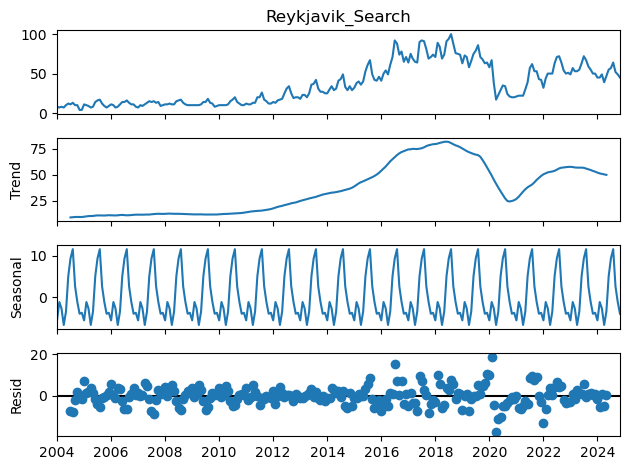

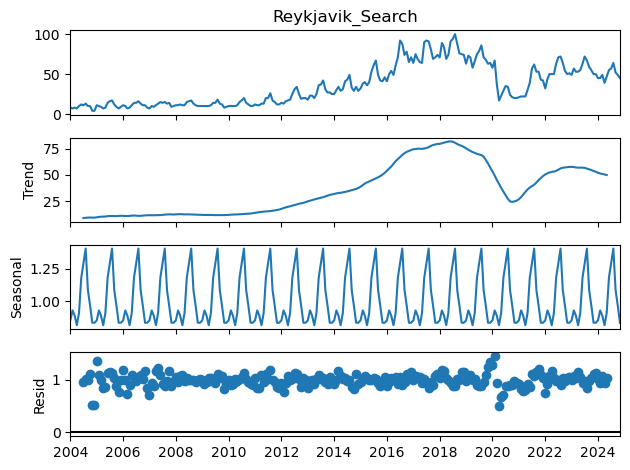

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
plt.figure(figsize=(10, 6))
# Original data plot
decomposition_add = seasonal_decompose(data['Reykjavik_Search'], model='additive')
decomposition_mult = seasonal_decompose(data['Reykjavik_Search'], model='multiplicative')
# Plot both decompositions
decomposition_add.plot()
decomposition_mult.plot()
plt.show()

Additive due the most stable residual components. (Really can´t see any other difference)

Frequency: 12 (monthly data)
Trend: Long-term from 2004 to 2016, drop in 2020, and some recovery after that.
Seasonality: Regular monthly patterns, maybe due to tourist season.
Cycles: Large, with a disruption likely for the pandemic.
Noise: Relatively stable, except for a few outliers during volatile periods.


**Check if the data is stationary**

In [232]:
result = adfuller(data['Reykjavik_Search'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.058604123492258
p-value: 0.26148239759680003


Is the data stationary? why?

p-value >0.05 data is not stationary, the data has trends and seasonality.

ADF checks if the mean and variance don+t change over time. Lower values suggest data is stationary

If the data is not stationary, fix it here:

In [233]:

# First-order differencing
data_diff1 = data['Reykjavik_Search'].diff().dropna()
# Log transformation
data_log = np.log(data['Reykjavik_Search'])

# Seasonal differencing (if monthly data, usually lag=12)
data_diff_seasonal = data['Reykjavik_Search'].diff(12).dropna()

data_log_diff1 = data_log.diff().dropna()  # Log followed by first differencing
data_log_diff_seasonal = data_log.diff(12).dropna()  # Log followed by seasonal differencing
# ADF Test on transformed data
result = adfuller(data_log_diff1.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.4903008178510193
p-value: 0.008239711717188129


p-value less than 0.05, the data is stationary.
Log transformation stabilised the variance
First Diff removed the trend


Is the data stationary now? If not, fix it here:

In [234]:
# leave blank if the data is stationary

**Plot autocorrelation (ACF) and partial autocorrelation (PACF)** 

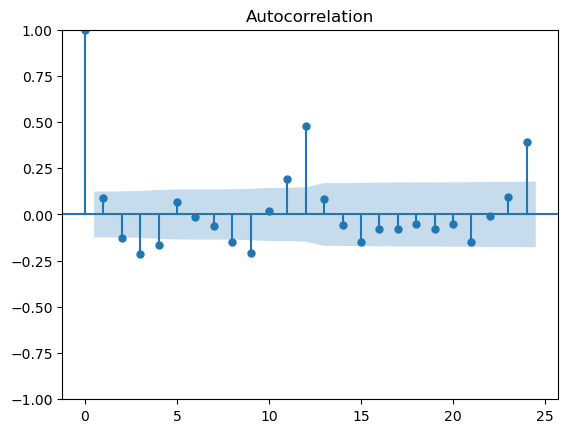

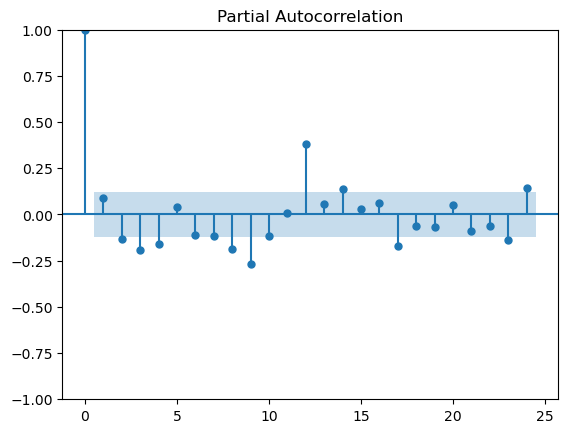

In [235]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_log_diff1)
plot_pacf(data_log_diff1)
plt.show()

Are there significant spikes? Which lags are significant?

YEs, In the Autocorrelation Function there are spikes around lag 1,12 and 24 due seasonality??
In the Partial Autocorrelation Function there are spikes around lag 2-12 

Lag 1 Indicates the series at one time point is highly related to its immediate previous value(1 month earlier)
If you’re looking at Google searches for "Reykjavik" in February, Lag 1 means February’s searches are strongly influenced by January’s searches.
Why: If people searched a lot in January, they likely continued searching in February (short-term dependence).

Lag 12 The value of the series at one point is related to the value 12 months earlier (1year earlier)
If there was a high number of searches for "Reykjavik" in July 2023, Lag 12 suggests that this is related to the number of searches in July 2022.
Why: Searches for "Reykjavik" might follow a seasonal pattern, such as more searches in summer (tourism season).

**(Bonus): Find Structural breaks**

The code has to be in R, you can run it on R studio and paste it here.

# Read the dataset (update the file path to your file location)
data <- read_csv("Monthly_Google_Search_Iceland_Reykjavik.csv")

# View the first few rows of the dataset to confirm it's loaded correctly
head(data)

# Define the 'Reykjavik_Search' column as a time series object
Reykjavik_Search <- ts(data$Reykjavik_Search, start = c(2004, 1), end = c(2024, 11), frequency = 12)

# Search for structural breaks
bp.Reykjavik <- breakpoints(Reykjavik_Search ~ 1, h = 0.1, breaks = 8) 

# Plot the breakpoint results
plot(bp.Reykjavik, main = "Bayesian Information Criterion (BIC) for Breakpoints")

# Plot observed and fitted time series with confidence intervals for the breakpoints
plot(Reykjavik_Search, main = "Structural Break Analysis", xlab = "Year", ylab = "Search Volume")
lines(fitted(bp.Reykjavik, breaks = 3), lwd = 3, col = 'blue')  # Fitted lines with 2 breaks
lines(confint(bp.Reykjavik, breaks = 3), lwd = 3)  # Confidence intervals for breakpoints

# Identify the confidence intervals for the breakpoints
break_conf_intervals <- confint(bp.Reykjavik, breaks = 2)
print(break_conf_intervals)

Are there any structural breaks? How many? When?


Using 8 breakpoints allows for a full exploration of the dataset to identify all potential changes, including  minor shifts in trends. The convergence of the BIC and RSS curves at point 5 indicates that beyond 5 breakpoints, adding more splits offers minimal improvement in fit (RSS) while increasing model complexity (BIC). This helps ensure that no significant changes are missed during the initial analysis

The 3-breakpoint structural analysis focuses on the most significant changes in the data, balancing simplicity and interpretability. These breakpoints capture key phases in the data, such as growth (2014–2015), a peak and plateau (around 2020), and the drop with stabilization (post-2021). By reducing the number of breakpoints, the model avoids overfitting and highlights only meaningful, impactful shifts in the dataset.

Changing breaks=3. This changes showed 3 clear breaks points in the data:
1 2014-15: an increase in search volume, possibly to Reykjavik´s popularity as travel destination.
2 2020: Covid-19 pandemic and traveling restrictions
3 2021: A recovery in the search volume.





**Preprocessing**

**1. Remove trends and seasonality**

In [236]:
# Step 1: Removing Trend using Differencing
data_diff = data.diff().dropna()

# Step 2: Removing Seasonality using Seasonal Decomposition
decomposition = seasonal_decompose(data, model='multiplicative', period=12)
data_deseasonalized = data.Reykjavik_Search / decomposition.seasonal
data_deseasonalized = data_deseasonalized.dropna()

**2. Smooth out the outliers**

In [237]:
# Applying a rolling window to smooth the data
window_size = 3  # you can adjust this depending on the level of smoothing needed
data_smoothed = data_deseasonalized.rolling(window=window_size, center=True).mean()
data_smoothed = data_smoothed.dropna()

**3. Plot the results**

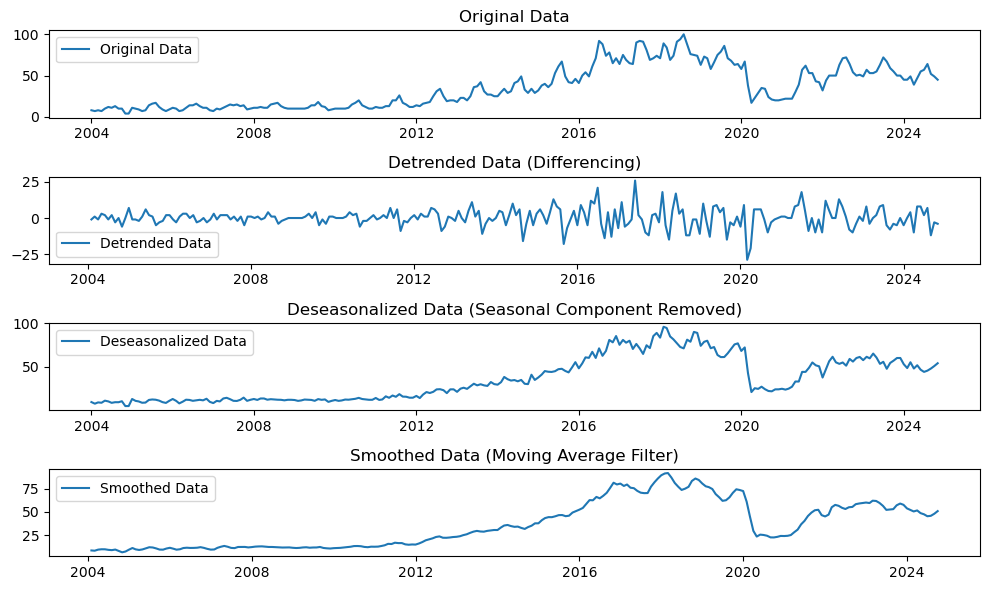

In [238]:
# Plotting the Results
plt.figure(figsize=(10, 6))

plt.subplot(4, 1, 1)
plt.plot(data, label="Original Data")
plt.title("Original Data")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data_diff, label="Detrended Data")
plt.title("Detrended Data (Differencing)")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data_deseasonalized, label="Deseasonalized Data")
plt.title("Deseasonalized Data (Seasonal Component Removed)")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(data_smoothed, label="Smoothed Data")
plt.title("Smoothed Data (Moving Average Filter)")
plt.legend()

plt.tight_layout()
plt.show()

Is there a lot of difference? What can you say about the original data seeing the difference with the preprocessed one?


Yes, there is a  difference between the original data and the preprocessed versions. 

Detrended Data: The trend is removed, leaving fluctuations around a relatively constant mean. This highlights short-term variations and reduces long-term biases.
Deseasonalized Data: By removing recurring patterns (seasonality), the data becomes easier to analyze for non-seasonal trends and changes.
Smoothed Data: Outliers and noise are reduced , making the overall patterns more visible and interpretable.

Original Data: Contains a mix of long-term trends, seasonal patterns, and noise. These components can make analysis difficult as they overlap.
Preprocessed Data:
Detrended Data: There’s a clear upward trend in the original data that masks short-term changes.
Deseasonalized Data:Significant seasonal fluctuations were present, but now the focus is on non-seasonal trends.
Smoothed Data:Some extreme outliers were likely present in the original data, which are now minimized.


The preprocessing steps help isolate the core signals in the data, making it easier to:
Identify patterns (e.g., structural changes).
Model and forecast without being misled by trends, seasonality, or noise.
The original data is rich in information but needs preprocessing to remove the overlapping components for clear insights.

**Split the data in train and test** and plot the result

Experiment with different train-test splits/forecasting horizons (1 for 1 point, 3 for the possibility of having 3 points) to determine which prediction horizon yields the best results for various models. The primary aim is to observe and compare how each model performs under varying conditions and to identify scenarios where one model outperforms others.

Task: Use the models presented in the *TimeSeriesNotebook.ipynb* to **forecast** your time series data. Then, **evaluate** the performance of each model both through **manual validation** and **cross-validation (bonus)**.

Examples (train,test) : (0.8 * data,0.2 * data) ; (0.7 * data,0.3 * data); (0.6 * data, 0.4 * data); but also fixed numbers like (x, y) (for a dataset of x+y length)

**Forecasting: Choose between 3-5 models presented**

**80-20**

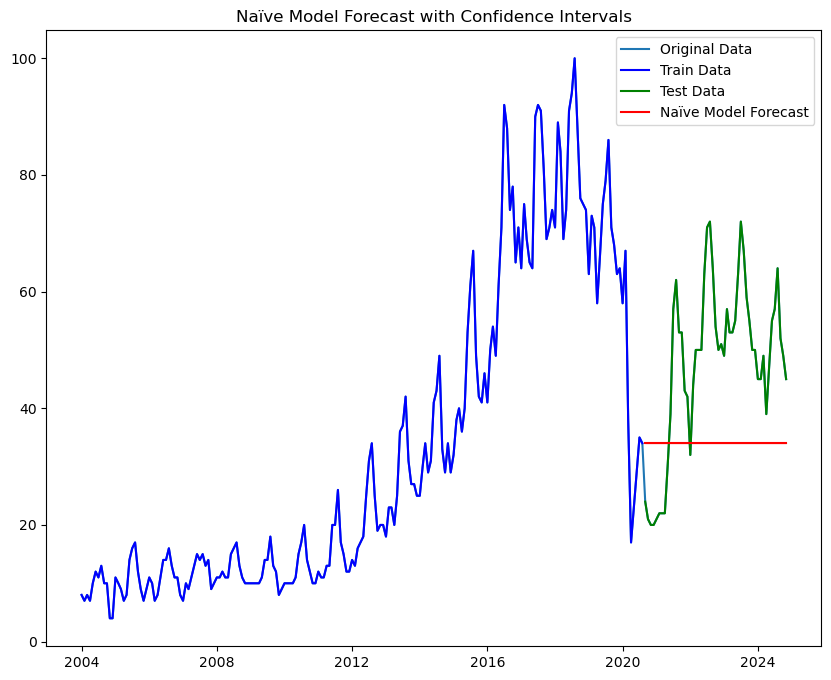

In [264]:
# Forecast horizon
# Train-test split
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]
forecast_horizon = len(test)
# Helper function to calculate and plot forecast
def plot_forecast(forecast, model_name):
    plt.figure(figsize=(10, 8))
    plt.plot(data, label="Original Data")
    plt.plot(train, label="Train Data", color="blue")
    plt.plot(test, label="Test Data", color="green")
    plt.plot(forecast, label=f"{model_name} Forecast", color="red")
    plt.fill_between(forecast.index, forecast - 1.96 * forecast.std(), forecast + 1.96 * forecast.std(), color='red', alpha=0.2)
    plt.title(f"{model_name} Forecast with Confidence Intervals")
    plt.legend()
    plt.show()
# 1. Naïve Forecasting Model
# Extract the last numeric value from the training data
last_value = train['Reykjavik_Search'].iloc[-1]

# Create the forecast by repeating this value for each point in the forecast horizon
naive_forecast = pd.Series([last_value] * len(test), index=test.index)

# Plot the forecast
plot_forecast(naive_forecast, "Naïve Model")


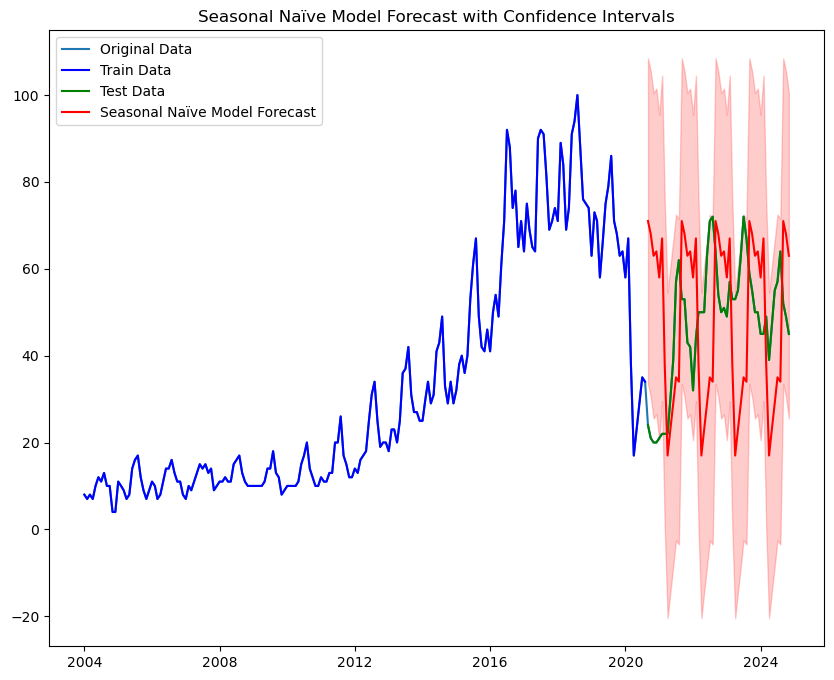

In [265]:
# Seasonal Naïve Model
seasonal_period = 12  # Assuming monthly data with annual seasonality

# Create the seasonal forecast by repeating the last full seasonal cycle
seasonal_naive_values = (train['Reykjavik_Search'].iloc[-seasonal_period:].values.tolist() * (len(test) // seasonal_period + 1))[:len(test)]
seasonal_naive_forecast = pd.Series(seasonal_naive_values, index=test.index)

# Plot the forecast
plot_forecast(seasonal_naive_forecast, "Seasonal Naïve Model")

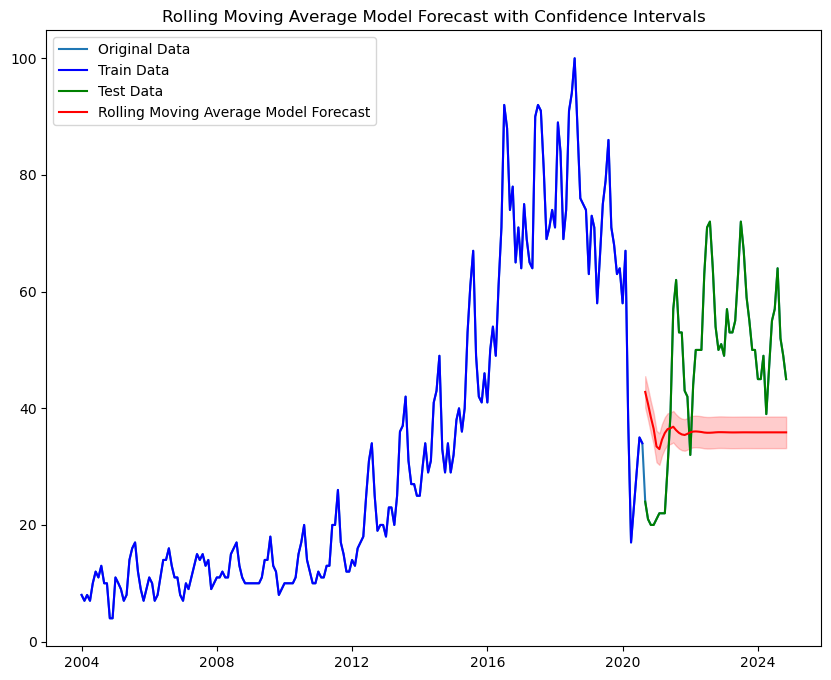

In [266]:
# Rolling Moving Average Model
moving_avg_window = 10  # Try different windows if needed

# Initialize an empty list to store predictions
rolling_moving_avg_forecast = []

# Loop through each test period to update the rolling forecast
for i in range(len(test)):
    # Calculate moving average using the latest values from the training set + any predicted values
    if i == 0:
        # Initial prediction based on the last moving average from the training set
        avg = train['Reykjavik_Search'].rolling(window=moving_avg_window).mean().iloc[-1]
    else:
        # Rolling window based on previous predictions in the test period
        avg = pd.concat([train['Reykjavik_Search'], pd.Series(rolling_moving_avg_forecast)], ignore_index=True).rolling(window=moving_avg_window).mean().iloc[-1]
    
    rolling_moving_avg_forecast.append(avg)

# Convert to Series and plot
rolling_moving_avg_forecast_series = pd.Series(rolling_moving_avg_forecast, index=test.index)
plot_forecast(rolling_moving_avg_forecast_series, "Rolling Moving Average Model")

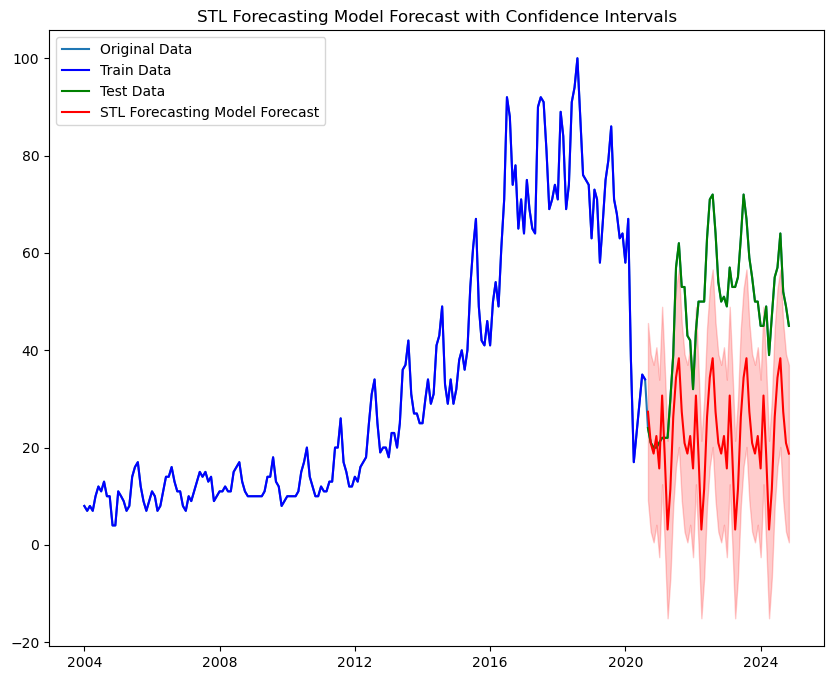

In [267]:
# Perform STL decomposition
stl = STL(train['Reykjavik_Search'], seasonal=13)  # Assuming monthly seasonality
result = stl.fit()

# Forecast based on the trend and seasonality components
trend_forecast = result.trend.iloc[-1]  # Last observed trend level
seasonal_forecast = result.seasonal[-seasonal_period:]  # Repeat last season
seasonal_forecast = pd.Series(np.tile(seasonal_forecast.values, len(test) // seasonal_period + 1)[:len(test)], index=test.index)

# Combine trend and seasonality for final forecast
stl_forecast = trend_forecast + seasonal_forecast

# Plot the forecast
plot_forecast(stl_forecast, "STL Forecasting Model")

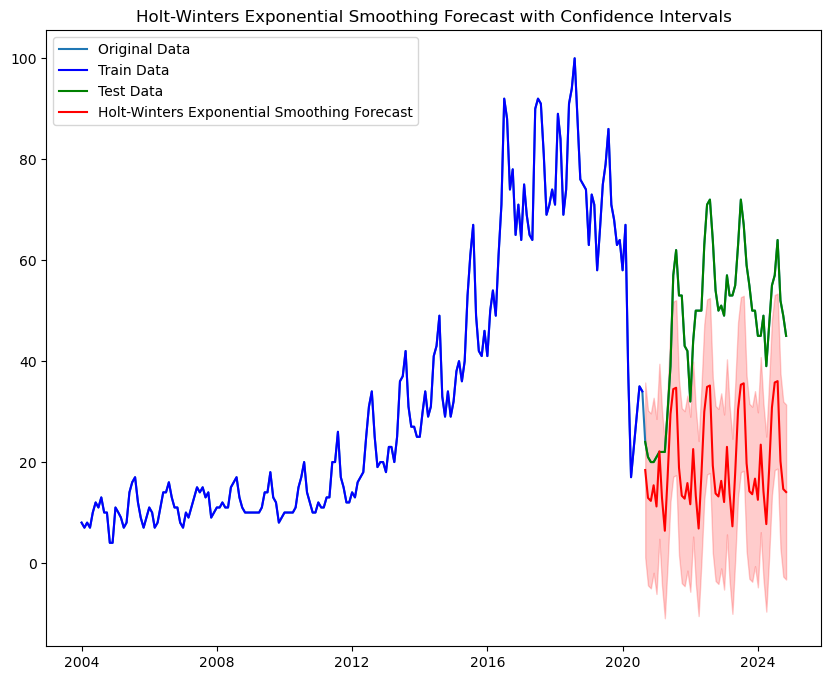

In [268]:
# Holt-Winters Exponential Smoothing
model_hw = ExponentialSmoothing(train['Reykjavik_Search'], seasonal='add', trend='add', seasonal_periods=12)
model_hw_fit = model_hw.fit()

# Forecast
hw_forecast = model_hw_fit.forecast(steps=len(test))

# Plot the forecast
plot_forecast(hw_forecast, "Holt-Winters Exponential Smoothing")

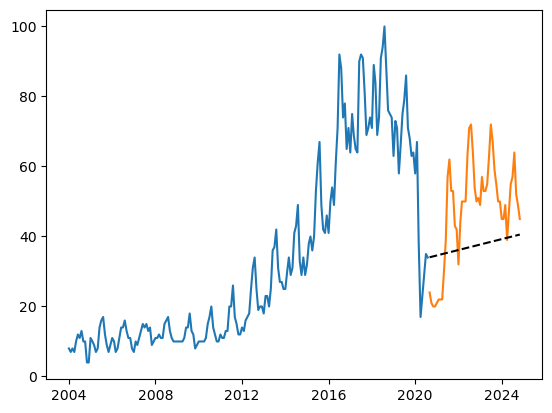

In [269]:
ARIMA_model = ARIMA(train["Reykjavik_Search"], order=(1,2,1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_pred = ARIMA_model_fit.get_prediction(start=len(train), end=len(train) + len(test) - 1).predicted_mean 
plt.plot(train["Reykjavik_Search"])
plt.plot(test["Reykjavik_Search"])
plt.plot(ARIMA_pred, 'k--', label='ARIMA') 
plt.show()

In [270]:
results = {
    "Model": ["Naïve","Seasonal Naïve","Rolling Moving Average", "STL", "Holt-Winters", "ARIMA"],
    "MSE": [
        mean_squared_error(test, naive_forecast),
        mean_squared_error(test, seasonal_naive_forecast),
        mean_squared_error(test, rolling_moving_avg_forecast),
        mean_squared_error(test, stl_forecast),
        mean_squared_error(test, hw_forecast),
        mean_squared_error(test, ARIMA_pred),
    ],
    "MAE": [
        mean_absolute_error(test, naive_forecast),
        mean_absolute_error(test, seasonal_naive_forecast),
        mean_absolute_error(test, rolling_moving_avg_forecast),
        mean_absolute_error(test, stl_forecast),
        mean_absolute_error(test, hw_forecast),
        mean_absolute_error(test, ARIMA_pred)
    ]
}

results_df = pd.DataFrame(results)
results_df


,Model,MSE,MAE
0,Naïve,390.666667,17.843137
1,Seasonal Naïve,673.176471,23.254902
2,Rolling Moving Average,348.530840,16.856215
3,STL,811.494469,25.929030
4,Holt-Winters,932.452025,28.275777
5,ARIMA,284.291521,14.855245


Majority of the data with a small part for test.
The model may need more test data.

In this case ARIMA seems to be the best performer with Mean Squared error of 284 and Mean absolute error of 14. 
Followed for the Rolling and the Naive.
holt is the worst probably for overfiting or couldnt capture the seasonal patterns in data.

**70-30**

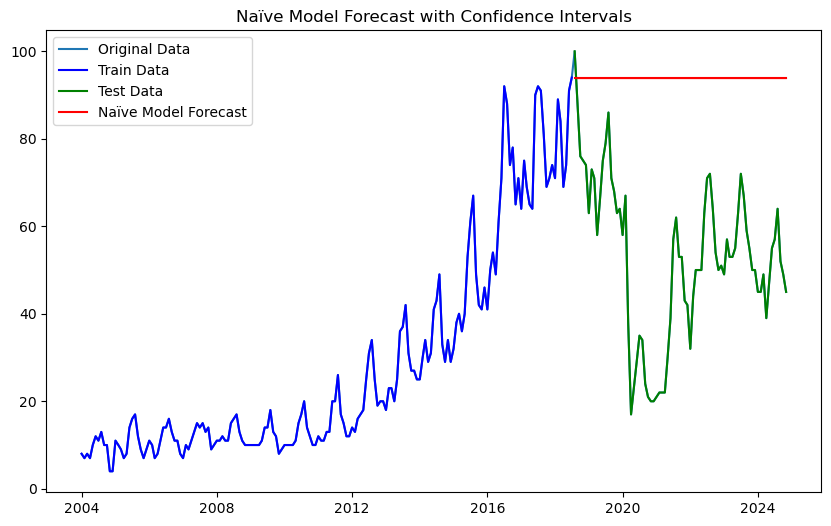

In [272]:
# Train-test split
train_size = int(0.7 * len(data))
train, test = data[:train_size], data[train_size:]
forecast_horizon = len(test)
# Helper function to calculate and plot forecast
def plot_forecast(forecast, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label="Original Data")
    plt.plot(train, label="Train Data", color="blue")
    plt.plot(test, label="Test Data", color="green")
    plt.plot(forecast, label=f"{model_name} Forecast", color="red")
    plt.fill_between(forecast.index, forecast - 1.96 * forecast.std(), forecast + 1.96 * forecast.std(), color='red', alpha=0.2)
    plt.title(f"{model_name} Forecast with Confidence Intervals")
    plt.legend()
    plt.show()
# 1. Naïve Forecasting Model
# Extract the last numeric value from the training data
last_value = train['Reykjavik_Search'].iloc[-1]

# Create the forecast by repeating this value for each point in the forecast horizon
naive_forecast = pd.Series([last_value] * len(test), index=test.index)

# Plot the forecast
plot_forecast(naive_forecast, "Naïve Model")# Model 1 : ...

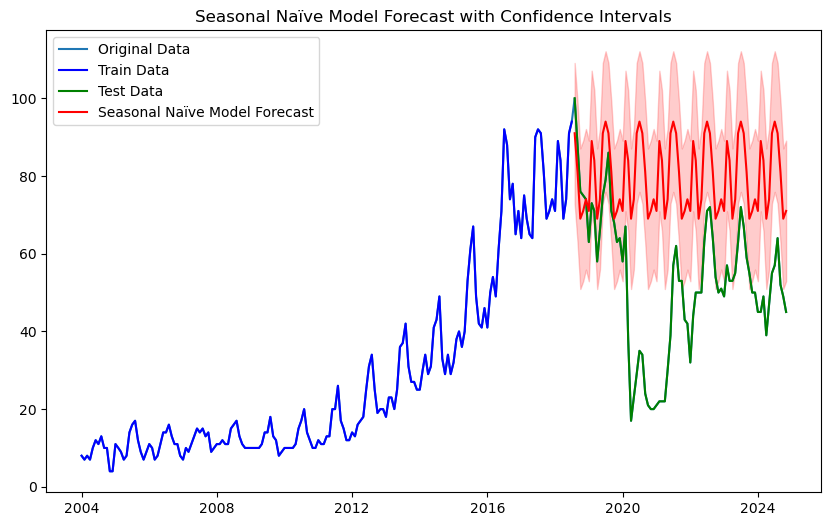

In [273]:
# Seasonal Naïve Model
seasonal_period = 12  # Assuming monthly data with annual seasonality

# Create the seasonal forecast by repeating the last full seasonal cycle
seasonal_naive_values = (train['Reykjavik_Search'].iloc[-seasonal_period:].values.tolist() * (len(test) // seasonal_period + 1))[:len(test)]
seasonal_naive_forecast = pd.Series(seasonal_naive_values, index=test.index)

# Plot the forecast
plot_forecast(seasonal_naive_forecast, "Seasonal Naïve Model")


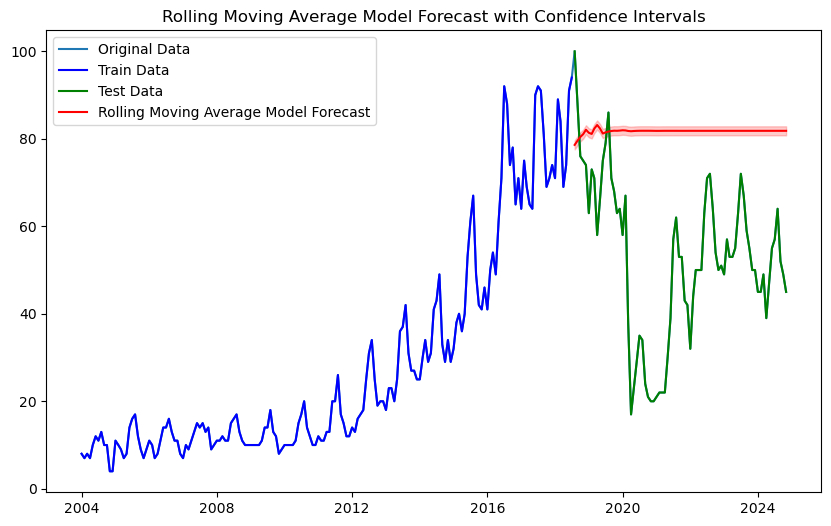

In [274]:
# Rolling Moving Average Model
moving_avg_window = 10  # Try different windows if needed

# Initialize an empty list to store predictions
rolling_moving_avg_forecast = []

# Loop through each test period to update the rolling forecast
for i in range(len(test)):
    # Calculate moving average using the latest values from the training set + any predicted values
    if i == 0:
        # Initial prediction based on the last moving average from the training set
        avg = train['Reykjavik_Search'].rolling(window=moving_avg_window).mean().iloc[-1]
    else:
        # Rolling window based on previous predictions in the test period
        avg = pd.concat([train['Reykjavik_Search'], pd.Series(rolling_moving_avg_forecast)], ignore_index=True).rolling(window=moving_avg_window).mean().iloc[-1]
    
    rolling_moving_avg_forecast.append(avg)

# Convert to Series and plot
rolling_moving_avg_forecast_series = pd.Series(rolling_moving_avg_forecast, index=test.index)
plot_forecast(rolling_moving_avg_forecast_series, "Rolling Moving Average Model")


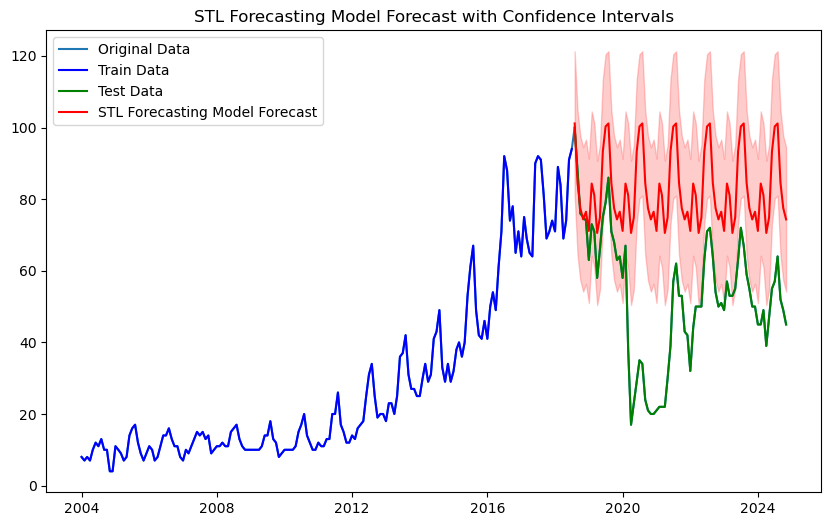

In [275]:
# Perform STL decomposition
stl = STL(train['Reykjavik_Search'], seasonal=13)  # Assuming monthly seasonality
result = stl.fit()

# Forecast based on the trend and seasonality components
trend_forecast = result.trend.iloc[-1]  # Last observed trend level
seasonal_forecast = result.seasonal[-seasonal_period:]  # Repeat last season
seasonal_forecast = pd.Series(np.tile(seasonal_forecast.values, len(test) // seasonal_period + 1)[:len(test)], index=test.index)

# Combine trend and seasonality for final forecast
stl_forecast = trend_forecast + seasonal_forecast

# Plot the forecast
plot_forecast(stl_forecast, "STL Forecasting Model")


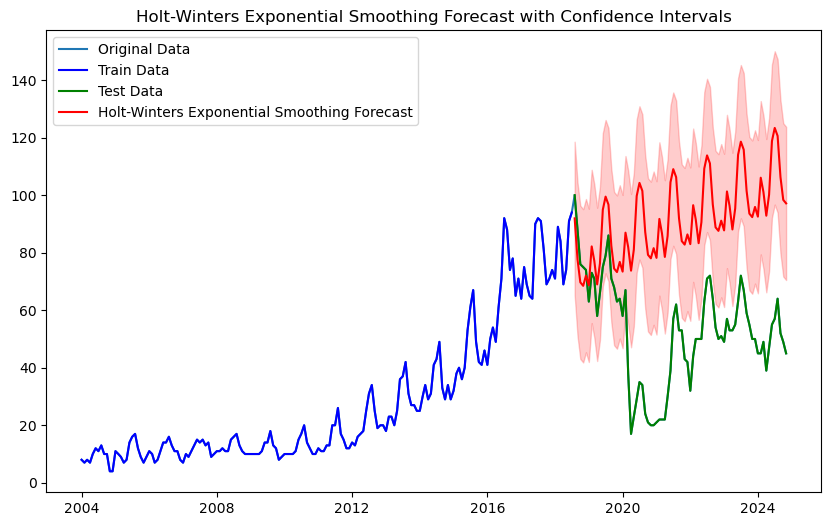

In [276]:
# Holt-Winters Exponential Smoothing
model_hw = ExponentialSmoothing(train['Reykjavik_Search'], seasonal='add', trend='add', seasonal_periods=12)
model_hw_fit = model_hw.fit()

# Forecast
hw_forecast = model_hw_fit.forecast(steps=len(test))

# Plot the forecast
plot_forecast(hw_forecast, "Holt-Winters Exponential Smoothing")

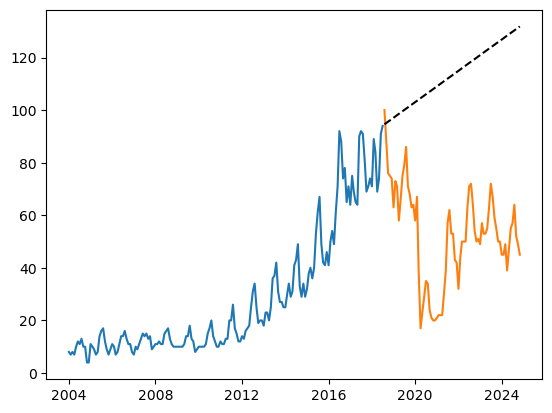

In [277]:
ARIMA_model = ARIMA(train["Reykjavik_Search"], order=(1,2,1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_pred = ARIMA_model_fit.get_prediction(start=len(train), end=len(train) + len(test) - 1).predicted_mean
plt.plot(train["Reykjavik_Search"])
plt.plot(test["Reykjavik_Search"])
plt.plot(ARIMA_pred, 'k--', label='ARIMA') 
plt.show()

In [278]:
results = {
    "Model": ["Naïve","Seasonal Naïve","Rolling Moving Average", "STL", "Holt-Winters", "ARIMA"],
    "MSE": [
        mean_squared_error(test, naive_forecast),
        mean_squared_error(test, seasonal_naive_forecast),
        mean_squared_error(test, rolling_moving_avg_forecast),
        mean_squared_error(test, stl_forecast),
        mean_squared_error(test, hw_forecast),
        mean_squared_error(test, ARIMA_pred),
    ],
    "MAE": [
        mean_absolute_error(test, naive_forecast),
        mean_absolute_error(test, seasonal_naive_forecast),
        mean_absolute_error(test, rolling_moving_avg_forecast),
        mean_absolute_error(test, stl_forecast),
        mean_absolute_error(test, hw_forecast),
        mean_absolute_error(test, ARIMA_pred)
    ]
}

results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE
0,Naïve,2053.750000,41.750000
1,Seasonal Naïve,1056.565789,28.039474
2,Rolling Moving Average,1191.322118,30.215275
3,STL,1195.593376,30.266177
4,Holt-Winters,1988.727306,40.142058
5,ARIMA,4220.634644,60.949419


Little bit more balanced allowing for a good training and testing.
In this case Seasonal Naive performs best, followed by Rolling and STL.
the worst are the Naive and ARIMA

**60-40**

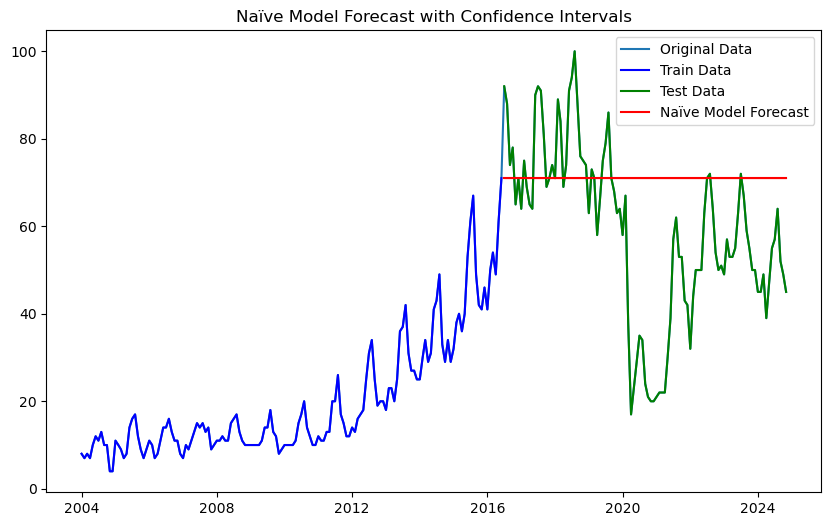

In [280]:
# Train-test split
train_size = int(0.6 * len(data))
train, test = data[:train_size], data[train_size:]
forecast_horizon = len(test)
# Helper function to calculate and plot forecast
def plot_forecast(forecast, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label="Original Data")
    plt.plot(train, label="Train Data", color="blue")
    plt.plot(test, label="Test Data", color="green")
    plt.plot(forecast, label=f"{model_name} Forecast", color="red")
    plt.fill_between(forecast.index, forecast - 1.96 * forecast.std(), forecast + 1.96 * forecast.std(), color='red', alpha=0.2)
    plt.title(f"{model_name} Forecast with Confidence Intervals")
    plt.legend()
    plt.show()
# 1. Naïve Forecasting Model
# Extract the last numeric value from the training data
last_value = train['Reykjavik_Search'].iloc[-1]

# Create the forecast by repeating this value for each point in the forecast horizon
naive_forecast = pd.Series([last_value] * len(test), index=test.index)

# Plot the forecast
plot_forecast(naive_forecast, "Naïve Model")

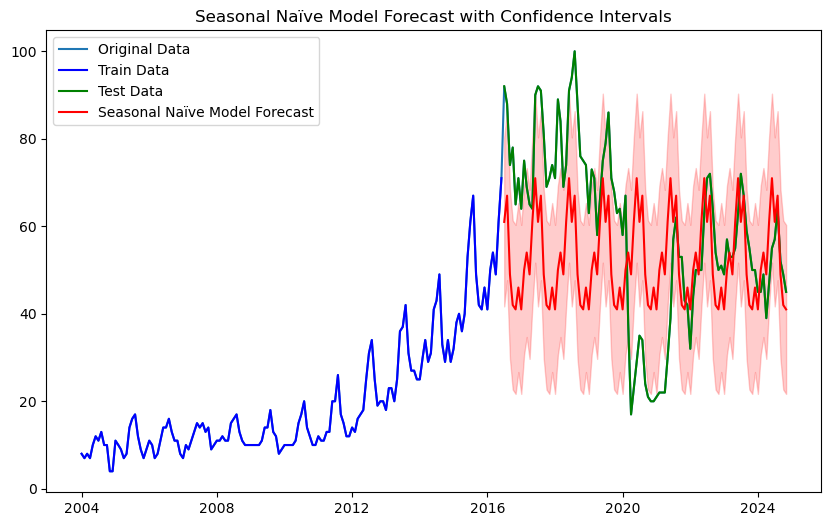

In [281]:
# Seasonal Naïve Model
seasonal_period = 12  # Assuming monthly data with annual seasonality

# Create the seasonal forecast by repeating the last full seasonal cycle
seasonal_naive_values = (train['Reykjavik_Search'].iloc[-seasonal_period:].values.tolist() * (len(test) // seasonal_period + 1))[:len(test)]
seasonal_naive_forecast = pd.Series(seasonal_naive_values, index=test.index)

# Plot the forecast
plot_forecast(seasonal_naive_forecast, "Seasonal Naïve Model")

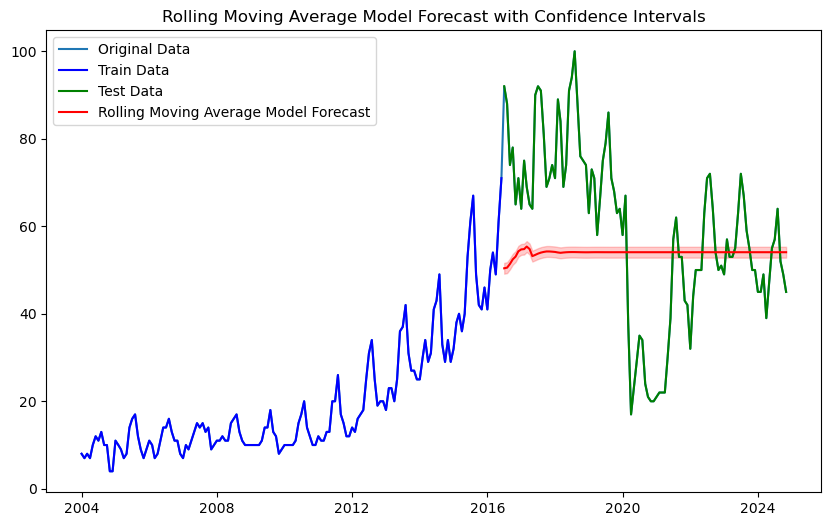

In [282]:
# Rolling Moving Average Model
moving_avg_window = 10  # Try different windows if needed

# Initialize an empty list to store predictions
rolling_moving_avg_forecast = []

# Loop through each test period to update the rolling forecast
for i in range(len(test)):
    # Calculate moving average using the latest values from the training set + any predicted values
    if i == 0:
        # Initial prediction based on the last moving average from the training set
        avg = train['Reykjavik_Search'].rolling(window=moving_avg_window).mean().iloc[-1]
    else:
        # Rolling window based on previous predictions in the test period
        avg = pd.concat([train['Reykjavik_Search'], pd.Series(rolling_moving_avg_forecast)], ignore_index=True).rolling(window=moving_avg_window).mean().iloc[-1]
    
    rolling_moving_avg_forecast.append(avg)

# Convert to Series and plot
rolling_moving_avg_forecast_series = pd.Series(rolling_moving_avg_forecast, index=test.index)
plot_forecast(rolling_moving_avg_forecast_series, "Rolling Moving Average Model")


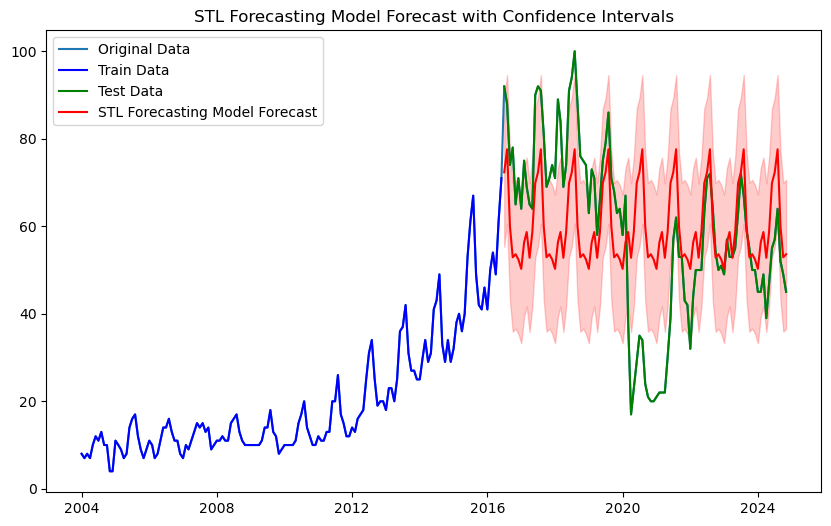

In [283]:
# Perform STL decomposition
stl = STL(train['Reykjavik_Search'], seasonal=13)  # Assuming monthly seasonality
result = stl.fit()

# Forecast based on the trend and seasonality components
trend_forecast = result.trend.iloc[-1]  # Last observed trend level
seasonal_forecast = result.seasonal[-seasonal_period:]  # Repeat last season
seasonal_forecast = pd.Series(np.tile(seasonal_forecast.values, len(test) // seasonal_period + 1)[:len(test)], index=test.index)

# Combine trend and seasonality for final forecast
stl_forecast = trend_forecast + seasonal_forecast

# Plot the forecast
plot_forecast(stl_forecast, "STL Forecasting Model")


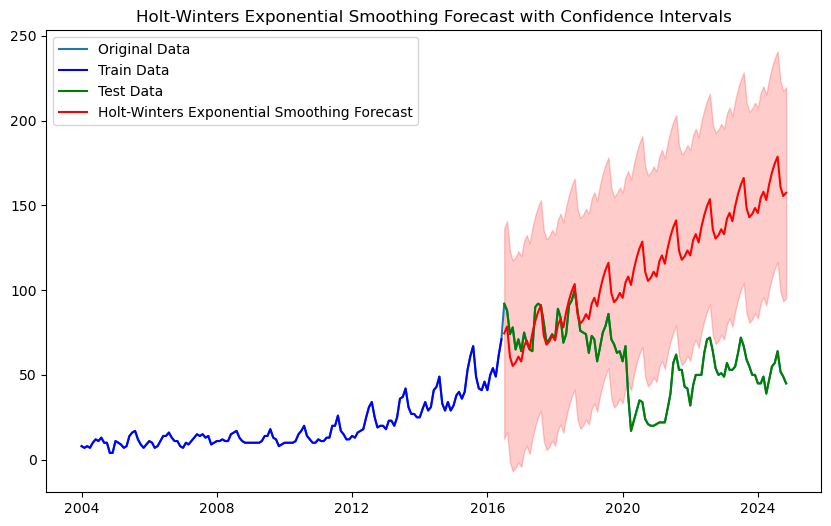

In [284]:
# Holt-Winters Exponential Smoothing
model_hw = ExponentialSmoothing(train['Reykjavik_Search'], seasonal='add', trend='add', seasonal_periods=12)
model_hw_fit = model_hw.fit()

# Forecast
hw_forecast = model_hw_fit.forecast(steps=len(test))

# Plot the forecast
plot_forecast(hw_forecast, "Holt-Winters Exponential Smoothing")

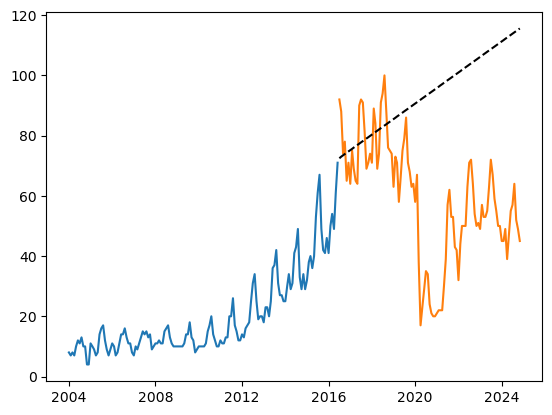

In [285]:
ARIMA_model = ARIMA(train["Reykjavik_Search"], order=(1,2,1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_pred = ARIMA_model_fit.get_prediction(start=len(train), end=len(train) + len(test) - 1).predicted_mean
plt.plot(train["Reykjavik_Search"])
plt.plot(test["Reykjavik_Search"])
plt.plot(ARIMA_pred, 'k--', label='ARIMA') 
plt.show()

In [286]:
results = {
    "Model": ["Naïve","Seasonal Naïve","Rolling Moving Average", "STL", "Holt-Winters", "ARIMA"],
    "MSE": [
        mean_squared_error(test, naive_forecast),
        mean_squared_error(test, seasonal_naive_forecast),
        mean_squared_error(test, rolling_moving_avg_forecast),
        mean_squared_error(test, stl_forecast),
        mean_squared_error(test, hw_forecast),
        mean_squared_error(test, ARIMA_pred),
    ],
    "MAE": [
        mean_absolute_error(test, naive_forecast),
        mean_absolute_error(test, seasonal_naive_forecast),
        mean_absolute_error(test, rolling_moving_avg_forecast),
        mean_absolute_error(test, stl_forecast),
        mean_absolute_error(test, hw_forecast),
        mean_absolute_error(test, ARIMA_pred)
    ]
}

results_df = pd.DataFrame(results)
results_df

,Model,MSE,MAE
0,Naïve,540.702970,18.069307
1,Seasonal Naïve,427.247525,17.405941
2,Rolling Moving Average,417.939318,16.644450
3,STL,342.245004,15.097756
4,Holt-Winters,4899.861385,57.452150
5,ARIMA,2053.910531,38.021001


Larger test data set but limits the model ability to learn the patterns on the data.
In this case STL is the one with best performance followed by Rolling and Seasonal Naive.
Also Holt winters has the worst performance, maybe it struggles with the extended test data and the variability.

**Evaluation**

Chose one of the errors used for the evaluation explained in class and use it to compare the models.

Which model is the best? For which forecasting horizon?

*#answer here*

**(Bonus): Cross-Validation**

In [ ]:
#Cross-Validation
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6)
# Dictionary to store MSE results for each model
results = {model: [] for model in ["Naive", "Moving Average", "Holt-Winters", "ARIMA"]}

# Model-specific functions
def naive_forecast(train, horizon):
    return np.repeat(train.iloc[-1], horizon)

def moving_average_forecast(train, window=3):
    return np.mean(train.iloc[-window:])

def holt_winters_forecast(train, horizon):
    model = ExponentialSmoothing(train, seasonal="add", seasonal_periods=12)
    fit = model.fit()
    return fit.forecast(horizon)

def arima_forecast(train, horizon):
    model = ARIMA(train, order=(1, 2, 1))
    fit = model.fit()
    return fit.forecast(horizon)
# Cross-validation loop using TimeSeriesSplit
for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]["Reykjavik_Search"]
    test_data = data.iloc[test_index]["Reykjavik_Search"]
    horizon = len(test_data)

    # Naive Model
    naive_pred = naive_forecast(train_data, horizon)
    results["Naive"].append(mean_squared_error(test_data, naive_pred))

    # Moving Average
    moving_avg_pred = moving_average_forecast(train_data, window=3)
    results["Moving Average"].append(mean_squared_error(test_data, [moving_avg_pred] * horizon))

    # Holt-Winters
    hw_pred = holt_winters_forecast(train_data, horizon)
    results["Holt-Winters"].append(mean_squared_error(test_data, hw_pred))

    # ARIMA
    arima_pred = arima_forecast(train_data, horizon)
    results["ARIMA"].append(mean_squared_error(test_data, arima_pred))
    # Calculate the mean MSE across all splits for each model
mean_mse_results = {model: np.mean(errors) for model, errors in results.items()}
print(mean_mse_results)

{'Naive': 359.09999999999997, 'Moving Average': 447.17142857142863, 'Holt-Winters': 425.1099755289601, 'ARIMA': 330.7399263282494}


Is the best model the same as before? For which forecasting horizon?

Naive 359.09 performs well capturing short term trends but struggling with seasonality or long term patterns.
Moving Average: 447.17 has a higher MSE than Naive. Smooths the noise but fails to capture seasonality or breakpoints.
Holt-Winters: 425.11 is better than the previous butnot as good as Naive or ARIMA, accounts for seasonalityand trends but probably overfits
ARIMA: 330 lowest mse indicating its ability to detect trends and seasons.

In the 80-20 split ARIMA was the best performer in the forecasting horizon.